# Experiment 1: Learning the radius of a sphere
We will try to learn the radius of a sphere by using our differentiable renderer. We are going to try two different rendering modes (flat and phong shading), once with edge subsampling and without.

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [2]:
experiment = 'gradient_test_1'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

With subsampling - Albedo:


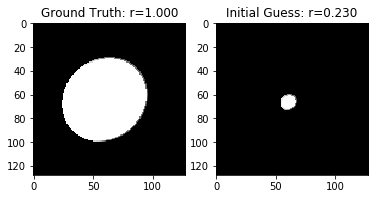

Without subsampling - Albedo:


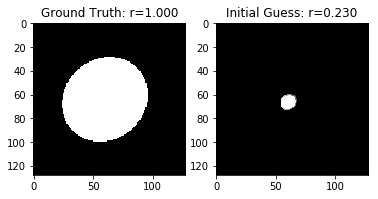

In [3]:
true_renderer = FlatRenderer(true_scene)
true_image_sub = true_renderer.forward()
true_image = true_renderer.forward(False)

pred_renderer = FlatRenderer(pred_scene)
pred_renderer.set_trainable({'ball_1': ['radius']})
pred_image_sub = pred_renderer.forward()
pred_image = pred_renderer.forward(True)
radius = t.detach_numpy(pred_renderer.ball_1['radius'])


print("With subsampling - Albedo:")
true_image_sub.show_image('albedo', title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
pred_image_sub.show_image('albedo', title='Initial Guess: r=%.3f' % radius, subplot='122')
plt.show()

print("Without subsampling - Albedo:")
true_image.show_image('albedo', title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
pred_image.show_image('albedo', title='Initial Guess: r=%.3f' % radius, subplot='122')
plt.show()


And now with Phong Shading

With subsampling - Albedo:


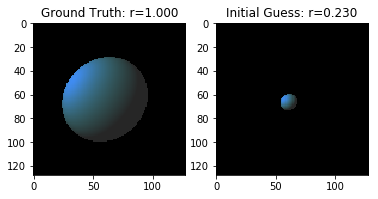

Without subsampling - Albedo:


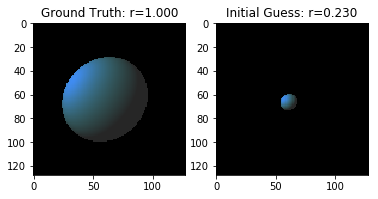

In [4]:
true_phong_renderer = PhongRenderer(true_scene)
true_phong_image_sub = true_phong_renderer.forward()
true_phong_image = true_phong_renderer.forward(False)

pred_phong_renderer = PhongRenderer(pred_scene)
pred_phong_renderer.set_trainable({'ball_1': ['radius']})
pred_phong_image_sub = pred_phong_renderer.forward()
pred_phong_image = pred_phong_renderer.forward(False)
radius = t.detach_numpy(pred_renderer.ball_1['radius'])


print("With subsampling - Albedo:")
true_phong_image_sub.show_image('albedo', title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
pred_phong_image_sub.show_image('albedo', title='Initial Guess: r=%.3f' % radius, subplot='122')
plt.show()

print("Without subsampling - Albedo:")
true_phong_image.show_image('albedo', title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
pred_phong_image.show_image('albedo', title='Initial Guess: r=%.3f' % radius, subplot='122')
plt.show()


Soft penalty regularizer with temperature $\tau > 0$:
$$p_\tau(r) = \tau \log(1 + \exp( -\frac{r}\tau )) 
\quad
\overset {\tau\rightarrow 0}\rightarrow 
\quad
- \min(r, 0) $$
Ensures $r > 0$ but has gradient everywhere compared to limit which is ReLU penalty. 

In [5]:
def soft_penalty(r, tau=.1):
    penalty = tau * t.log(1 + t.exp(-r / tau))
    return penalty

Use L2-image difference with smooth regularizer as loss:   
$$
\mathcal L(y, \hat y)
= \frac1 {WH} \| y- \hat y\|_{2} + p_{\tau}(r)
$$

This function will train our renderers

In [10]:
def train(ground_truth, renderer, subsampling=False, image_type='depth', iterations = 5000):
    suffix = "with subsampling" if subsampling else "without subsampling"
    print("Training a {0} regarding a {1} image ".format(pred_renderer.__class__.__name__, image_type) + suffix)
    loss_history = []
    
    renderer.set_trainable({'ball_1': ['radius']})
    params  = filter(lambda p: p.requires_grad, renderer.parameters())
    optimizer = optim.SGD(params, lr=0.1)

    for _ in range(iterations):

        renderer.clear()
        optimizer.zero_grad()

        predicition = renderer.forward(subsampling)
        r = renderer.ball_1['radius']
        loss = F.mse_loss(ground_truth.get_image(image_type), predicition.get_image(image_type))
        loss = loss + soft_penalty(r)
        loss.backward()
        optimizer.step()


        #history of intermediate losses and images 
        loss_history.append(t.detach_numpy(loss))

        if _ % (iterations/10) == 0:
            ground_truth.show_image(image_type, title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
            radius = renderer.ball_1['radius'].detach().cpu().numpy()
            predicition.show_image(image_type, title='Guess %d: r=%.3f' % (_+1,radius), subplot='122')
            plt.show()


    _ = np.arange(iterations)
    plt.plot(_, loss_history, label='loss')
    plt.xticks(np.arange(0,iterations+1,iterations//10))
    plt.legend()
    plt.show()


Now, let's try different trainings

Training a FlatRenderer regarding a albedo image without subsampling


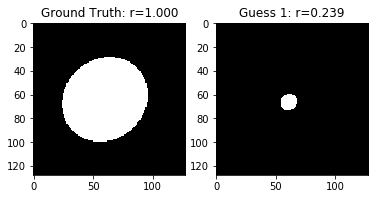

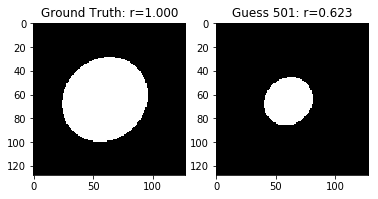

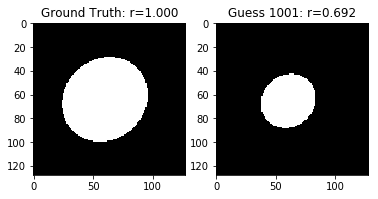

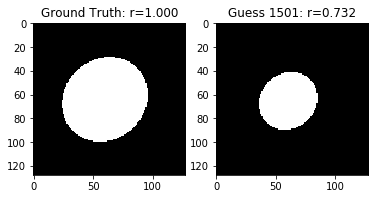

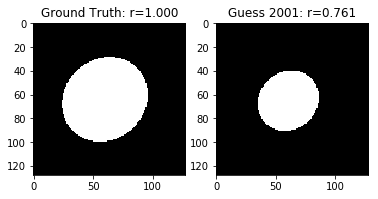

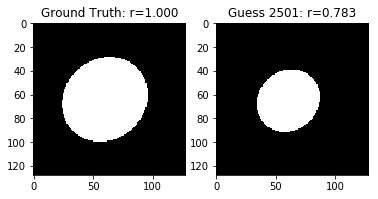

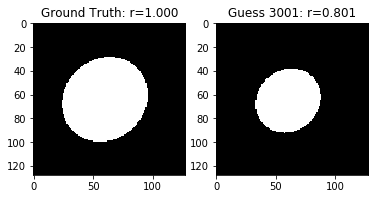

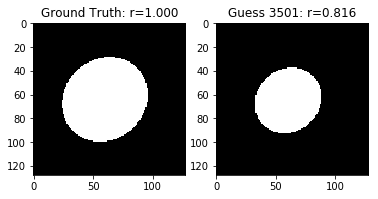

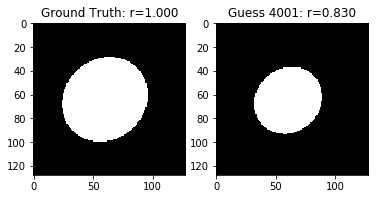

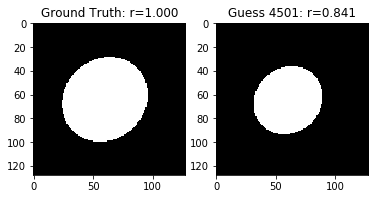

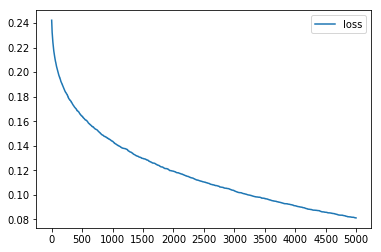

Training a FlatRenderer regarding a albedo image with subsampling


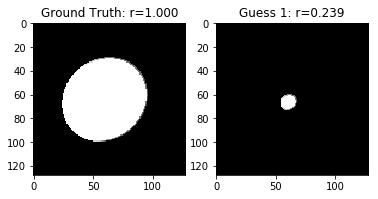

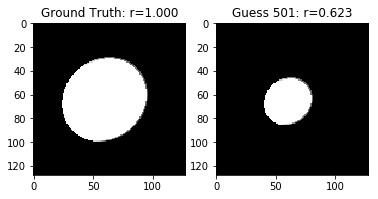

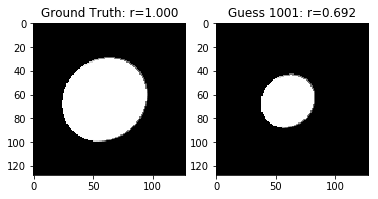

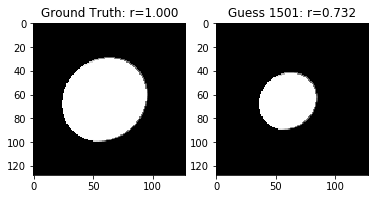

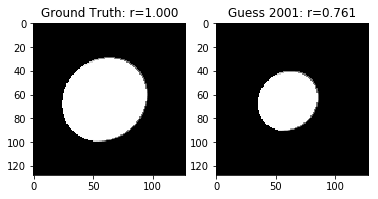

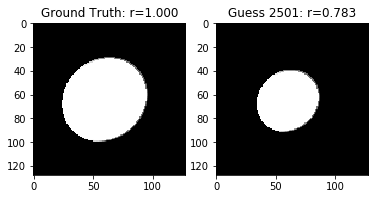

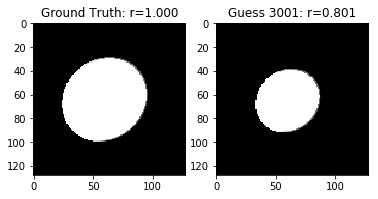

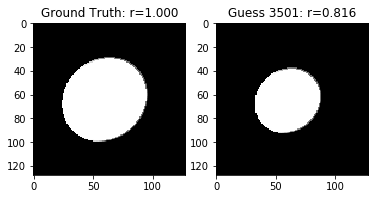

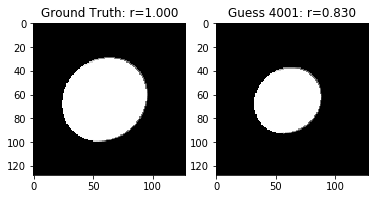

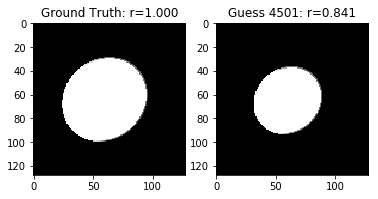

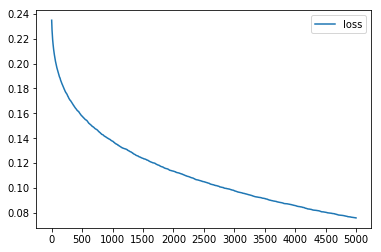

Training a FlatRenderer regarding a albedo image without subsampling


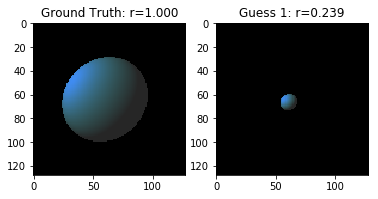

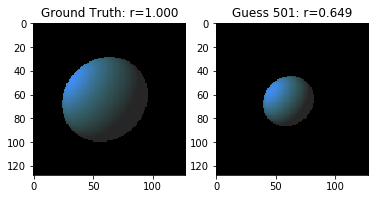

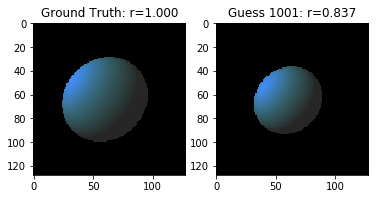

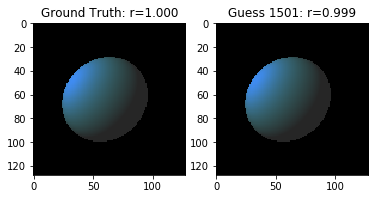

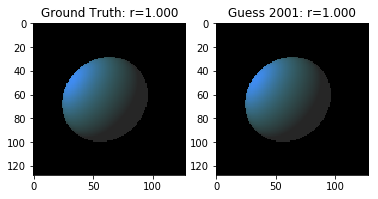

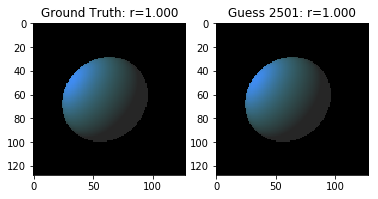

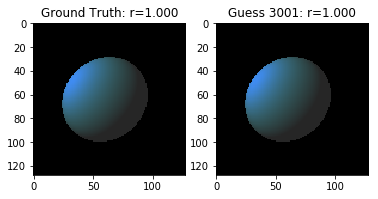

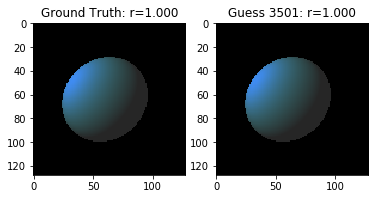

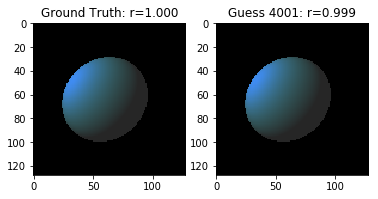

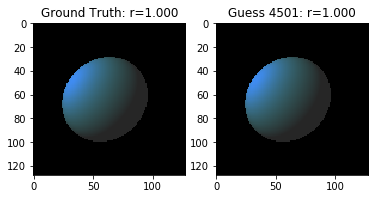

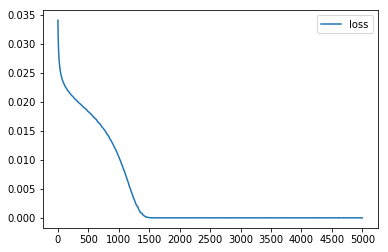

In [11]:

# Consider flat-shaded image without subsampling
flat_renderer = FlatRenderer(pred_scene)
train(true_image, flat_renderer, subsampling=False, image_type='albedo')

# Consider flat-shaded image with subsampling
flat_renderer_sub = FlatRenderer(pred_scene)
train(true_image_sub, flat_renderer_sub, subsampling=True, image_type='albedo')

# Consider phong-shaded image without subsampling
phong_renderer = PhongRenderer(pred_scene)
train(true_phong_image, phong_renderer, image_type='albedo')


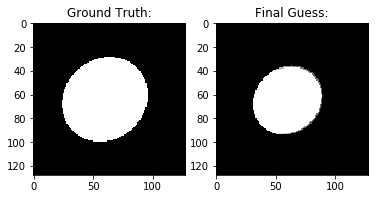

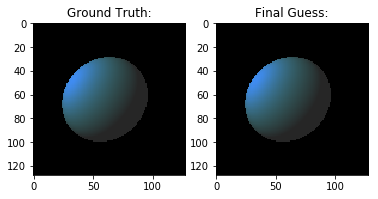

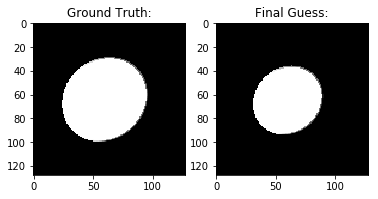

In [12]:
true_image.show_image('albedo', title='Ground Truth:', subplot='121')
flat_renderer.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()

true_phong_image.show_image('albedo', title='Ground Truth:', subplot='121')
phong_renderer.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()

true_image_sub.show_image('albedo', title='Ground Truth:', subplot='121')
flat_renderer_sub.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()